<a href="https://colab.research.google.com/github/alexlewis97/ISTRC-5-AM/blob/main/ISTRC_5_Adjacency_Matrix_construction_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data preparation

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('gdrive/MyDrive/לימודים תואר שני/thesis/data/data.csv')

In [ ]:
metadata = pd.read_csv('gdrive/MyDrive/לימודים תואר שני/thesis/metadata.txt', sep='\t')

In [ ]:
metadata.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
0,308511,50,E,3,17,NaN,31.627,60.162,38.761062,-120.569835,3.134,ML,2,Sly Park Rd,1,NaN,NaN,NaN
1,308512,50,W,3,17,NaN,31.627,60.166,38.761182,-120.569866,3.995,ML,2,Sly Park Rd,1,NaN,NaN,NaN
2,311832,5,S,3,67,NaN,10.896,506.189,38.409782,-121.484120,NaN,FR,1,Elk Grove Blvd,1,NaN,NaN,NaN
3,311844,5,N,3,67,NaN,11.105,506.398,38.412779,-121.484363,NaN,OR,3,Elk Grove Blvd 5NB Slip,1,NaN,NaN,NaN
4,311847,5,N,3,67,NaN,12.185,507.478,38.428258,-121.487578,NaN,OR,3,Laguna Blvd to 5NB Slip,1,NaN,NaN,NaN


In [ ]:
flow_df = data.pivot(index='Timestamp', columns='ID', values='Flow')
speed_df = data.pivot(index='Timestamp', columns='ID', values='Speed')

flow_df = flow_df.fillna(0)
speed_df = speed_df.fillna(0)

constant_zeros = speed_df.columns[speed_df.isin([0]).all()]

speed_df.drop(constant_zeros, axis=1, inplace=True)
flow_df = flow_df.loc[:, ~flow_df.columns.isin(constant_zeros)]

In [ ]:
adj = pd.read_csv('gdrive/MyDrive/לימודים תואר שני/thesis/adj_matrix_directed.csv')

In [ ]:
cols = []

for i in range(1, len(adj.columns)):
  cols.append(int(adj.columns[i]))

data = data[data['ID'].isin(cols)]

adj = adj.drop(columns=[str(col) for col in cols if col not in flow_df.columns])

In [ ]:
columns=[str(col) for col in cols if col not in flow_df.columns]

In [ ]:
adj = adj[~adj['ID'].isin(int(col) for col in columns)]

In [ ]:
adj = adj.iloc[:, :-1]

In [ ]:
adj = adj.set_index('ID')

In [ ]:
adj = adj[:-1]

In [ ]:
speed_df.shape, flow_df.shape, adj.shape

((8352, 1007), (8352, 1007), (988, 988))

In [ ]:
adj.columns

Index(['308511', '308512', '311903', '311974', '312010', '312098', '312103',
       '312132', '312133', '312134',
       ...
       '3420042', '3420051', '3420055', '3420058', '3420059', '3422101',
       '3422102', '3423061', '3423101', '3423105'],
      dtype='object', length=988)

In [ ]:
flow_df.columns

Index([ 308511,  308512,  311903,  311974,  312010,  312098,  312103,  312132,
        312133,  312134,
       ...
       3420058, 3420059, 3422101, 3422102, 3423061, 3423091, 3423094, 3423101,
       3423105, 3423106],
      dtype='int64', name='ID', length=1007)

In [ ]:
missing_columns = [col for col in flow_df.columns if str(col) not in adj.columns]
missing_columns

[316699,
 316704,
 318611,
 318612,
 318619,
 318620,
 3005052,
 3025111,
 3025112,
 3025113,
 3025114,
 3045021,
 3045022,
 3088011,
 3088012,
 3089061,
 3423091,
 3423094,
 3423106]

In [ ]:
flow_df.drop(missing_columns, axis=1, inplace=True)
speed_df.drop(missing_columns, axis=1, inplace=True)

In [ ]:
speed_df.shape, flow_df.shape, adj.shape

((8352, 988), (8352, 988), (988, 988))

# Create Distance-based matrix


In [ ]:
!pip install haversine

In [ ]:
import haversine

def create_distance_matrix(a):
  # Get the coordinates of each station from the metadata dataframe.
  longitude = metadata.set_index('ID')['Longitude'].to_dict()
  latitude = metadata.set_index('ID')['Latitude'].to_dict()
  coordinates = {id: ( latitude[id], longitude[id]) for id in a.columns}
  # Initialize the distance matrix.
  distance_matrix = np.zeros((len(a.columns), len(a.columns)))

  # Iterate over each pair of stations and calculate the distance.
  for i, index in enumerate(a.columns):
    for j, s_index in enumerate(a.columns):
      station_1_id = index
      station_2_id = s_index
      station_1_coordinates = coordinates[station_1_id]
      station_2_coordinates = coordinates[station_2_id]
      distance_matrix[i][j] = haversine.haversine(station_1_coordinates, station_2_coordinates)

  return distance_matrix

distance_matrix = create_distance_matrix(flow_df)


# Train val and test split

In [ ]:
flow_train = flow_df[0:6000]
flow_val = flow_df[6000:7000]
flow_test = flow_df[7000:]

speed_train = speed_df[0:6000]
speed_val = speed_df[6000:7000]
speed_test = speed_df[7000:]

# Similarity based matrix

In [ ]:
adj_similar = np.corrcoef(speed_train, rowvar=False)

In [ ]:
for i in range(len(adj_similar)):
  adj_similar[i][i] = 0

# Data to GCN LSTM format

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 24
forecast_horizon = 1
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    target_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        target_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset = create_tf_dataset(
    flow_train,
    flow_train,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

val_dataset = create_tf_dataset(
    flow_val,
    flow_val,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)


test_dataset = create_tf_dataset(
    flow_test,
    flow_test,
    input_sequence_length,
    forecast_horizon,
    batch_size=speed_test.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


In [ ]:
train_dataset.element_spec[0]

TensorSpec(shape=(None, None, 988, 1), dtype=tf.float64, name=None)

In [ ]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    #route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [ ]:
import typing

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(distance_matrix, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 988, number of edges: 3152


In [ ]:
import typing

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes

node_indices, neighbor_indices = np.where(adj_similar > 0.98)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adj.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 988, number of edges: 3448


In [ ]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [ ]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
        #add another lstm

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [ ]:
train_dataset

<CacheDataset element_spec=(TensorSpec(shape=(None, None, 988, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 988), dtype=tf.float64, name=None))>

In [ ]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 24
forecast_horizon = 1
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.00005),
    loss=keras.losses.MeanAbsoluteError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20
94/94 [==============================] - 8s 67ms/step - loss: 134.1485 - val_loss: 138.0503
Epoch 2/20
94/94 [==============================] - 6s 65ms/step - loss: 136.4696 - val_loss: 122.4408
Epoch 3/20
94/94 [==============================] - 6s 64ms/step - loss: 120.6268 - val_loss: 117.3374
Epoch 4/20
94/94 [==============================] - 6s 65ms/step - loss: 121.5798 - val_loss: 116.7764
Epoch 5/20
94/94 [==============================] - 6s 64ms/step - loss: 114.7248 - val_loss: 107.9821
Epoch 6/20
94/94 [==============================] - 6s 65ms/step - loss: 109.2666 - val_loss: 102.4356
Epoch 7/20
94/94 [==============================] - 6s 65ms/step - loss: 100.4838 - val_loss: 90.3618
Epoch 8/20
94/94 [==============================] - 6s 65ms/step - loss: 89.4852 - val_loss: 84.3539
Epoch 9/20
94/94 [==============================] - 6s 65ms/step - loss: 81.2729 - val_loss: 75.2613
Epoch 10/20
94/94 [==============================] - 6s 65ms/step - loss: 75.1

In [ ]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/100
94/94 [==============================] - 6s 65ms/step - loss: 49.3493 - val_loss: 46.3119
Epoch 2/100
94/94 [==============================] - 6s 65ms/step - loss: 47.5913 - val_loss: 43.9802
Epoch 3/100
94/94 [==============================] - 6s 65ms/step - loss: 46.2173 - val_loss: 44.4513
Epoch 4/100
94/94 [==============================] - 6s 65ms/step - loss: 44.8397 - val_loss: 42.4040
Epoch 5/100
94/94 [==============================] - 6s 65ms/step - loss: 42.2063 - val_loss: 40.8182
Epoch 6/100
94/94 [==============================] - 6s 65ms/step - loss: 42.3823 - val_loss: 42.7359
Epoch 7/100
94/94 [==============================] - 6s 65ms/step - loss: 41.4754 - val_loss: 37.7491
Epoch 8/100
94/94 [==============================] - 6s 65ms/step - loss: 37.2776 - val_loss: 34.3921
Epoch 9/100
94/94 [==============================] - 6s 65ms/step - loss: 35.2614 - val_loss: 34.6459
Epoch 10/100
94/94 [==============================] - 6s 65ms/step - loss: 36.6719

In [ ]:
# prompt: Save the model to my google drive

model.save('gdrive/MyDrive/לימודים תואר שני/thesis/models/flow_similarity_matrix_gnn_model.csv')


In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.000005),
    loss=keras.losses.MeanSquaredError(),
)

In [ ]:
x_test, y_test = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

42/42 [==============================] - 1s 14ms/step


In [ ]:
y_pred.shape

(1328, 1, 988)

In [ ]:
y_pred = y_pred.reshape((1328, 988))

In [ ]:
y_test = y_test.reshape((1328,988))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape = []
for i in range(0,y_pred.shape[1]):
  mape.append(mean_absolute_percentage_error(y_pred[:,i], y_test[:,i]))

mape_score = np.mean(mape)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape_score)

Mean Squared Error: 391.25397363801414
R-squared: 0.88127454310622
Mean Absolute Error: 12.18080630528549
Mean Absolute Percentage Error: 0.2920912707934699


In [ ]:
mape = []
for i in range(0,y_pred.shape[1]):
  mape.append(mean_absolute_percentage_error(y_pred[:,i], y_test[:,i]))

np.mean(mape)

0.2571591598954489

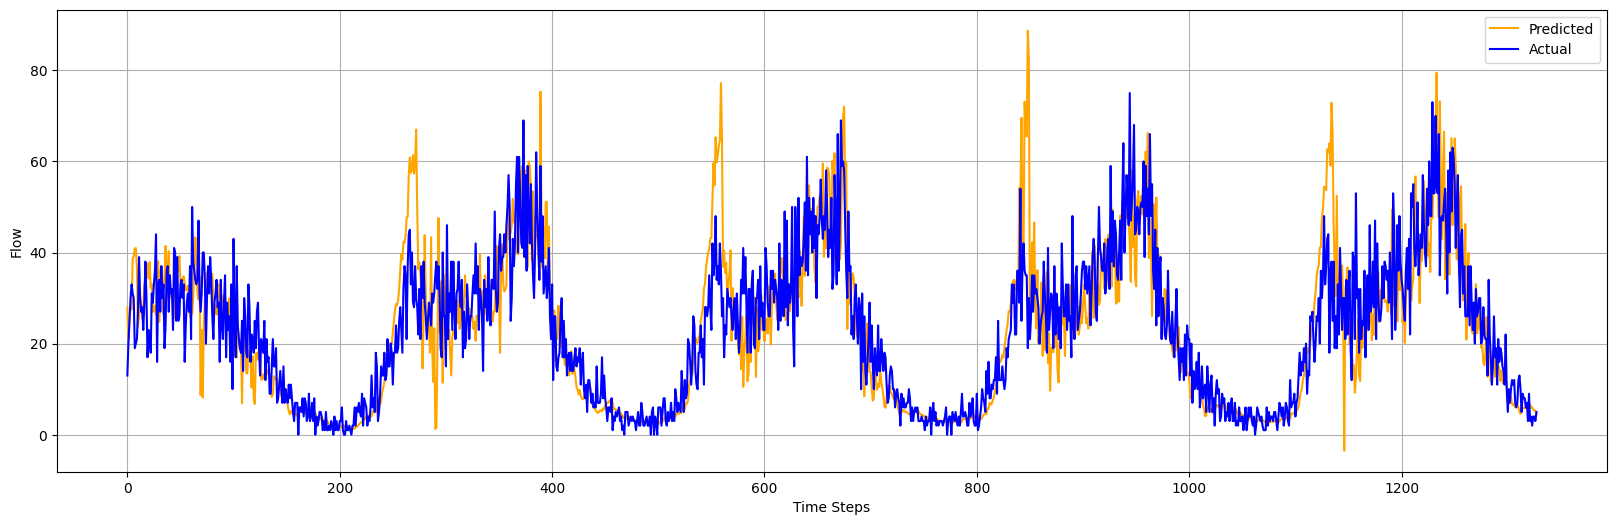

In [ ]:
# prompt: plot y_pred[:,200] against y_test[:,200] with a lot of detail

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(y_pred[:, 900], label="Predicted", color="orange")
plt.plot(y_test[:, 900], label="Actual", color="blue")
plt.xlabel("Time Steps")
plt.ylabel("Flow")
plt.legend()
plt.grid(True)
plt.show()



Similarity matrix:
Mean Squared Error: 783.8812972812642
R-squared: 0.7846006735635169
Mean Squared Error: 617.0413320574976
R-squared: 0.8360675520951083
Mean Squared Error: 591.0287452613019
R-squared: 0.8437972262248071

In [ ]:
y_pred

array([[ 17.524185 , 111.989876 , 203.08885  , ...,  32.15637  ,
        193.14922  , 106.882515 ],
       [ 17.581938 , 128.7065   , 218.39671  , ...,  30.039097 ,
        208.04787  , 110.177475 ],
       [ 19.101877 , 133.24242  , 258.88898  , ...,  34.213108 ,
        211.46123  ,  79.456    ],
       ...,
       [ 28.46982  ,  49.62264  , 144.6659   , ...,   8.241834 ,
        116.66648  ,  49.198387 ],
       [ 27.878859 ,  50.687973 , 120.70694  , ...,   8.080536 ,
        111.13677  ,  41.575893 ],
       [ 26.966677 ,  58.417942 , 117.494675 , ...,   7.1993427,
         86.43934  ,  37.544167 ]], dtype=float32)

In [ ]:
errors = {}
mse_arr = []
r = {}
r_arr = []
for i in range(988):
  col = y_test.columns[i]
  y_test_ind = y_test[col].values
  y_pred_ind = y_pred[:,i]

  mse = mean_squared_error(y_test_ind, y_pred_ind)
  r2 = r2_score(y_test_ind, y_pred_ind)
  mse_arr.append(mse)
  errors[i] = mse
  r_arr.append(r2)
  r[i] = r2

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
sum = 0
for i in range(988):
  if r[i] > 0.9:
    sum += 1
print(sum)